# Gaussian Mixture Model

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

seed = 0
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### toy dataset

In [2]:
# https://angusturner.github.io/generative_models/2017/11/03/pytorch-gaussian-mixture-model.html

def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

# generate some clusters
cluster1 = sample(
    torch.Tensor([1.5, 2.5]),
    torch.Tensor([1.2, .8]),
    nb_samples=150
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5]),
    nb_samples=50
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8]),
    nb_samples=100
)

def plot_2d_sample(sample_dict):
    fig = plt.figure(figsize=(5, 5))    

    x = samples_dict["x"][:,0].data.numpy()
    y = samples_dict["x"][:,1].data.numpy()
    plt.plot(x, y, 'gx')

    plt.show()

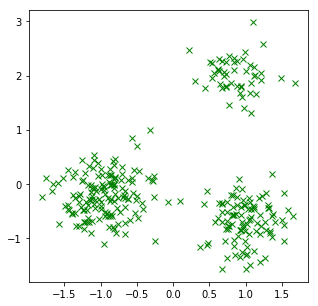

In [3]:
# create the dummy dataset, by combining the clusters.
samples = torch.cat([cluster1, cluster2, cluster3])
samples = (samples-samples.mean(dim=0)) / samples.std(dim=0)
samples_dict = {"x": samples}

plot_2d_sample(samples_dict)

## train GMM

In [4]:
from pixyz.distributions import Normal, Categorical, Bernoulli
from pixyz.distributions.mixture_distributions import MixtureModel

z_dim = 3 # the number of mixture
x_dim = 2

distributions = []
for i in range(z_dim):
    loc = torch.randn(x_dim)
    scale = torch.empty(x_dim).fill_(0.6)
    distributions.append(Normal(loc=loc, scale=scale, var=["x"], name="p_%d" %i))

probs = torch.empty(z_dim).fill_(1. / z_dim)
prior = Categorical(probs=probs, var=["z"], name="prior")

p = MixtureModel(distributions=distributions, prior=prior)
print(p)

Distribution:
  p(x) = p_0(x|z=0)prior(z=0) + p_1(x|z=1)prior(z=1) + p_2(x|z=2)prior(z=2)
Network architecture:
  MixtureModel(
    (_distributions): ModuleList(
      (0): Normal()
      (1): Normal()
      (2): Normal()
    )
    (_prior): Categorical()
  )


In [5]:
def get_density(N=200, x_range=(-5, 5), y_range=(-5, 5)):
    x = np.linspace(*x_range, N)
    y = np.linspace(*y_range, N)
    x, y = np.meshgrid(x, y)
    
    # get the design matrix
    points = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float()
    
    loglike = p.log_likelihood({"x": points}).exp_().data.numpy().reshape([N, N])
    
    return x, y, loglike

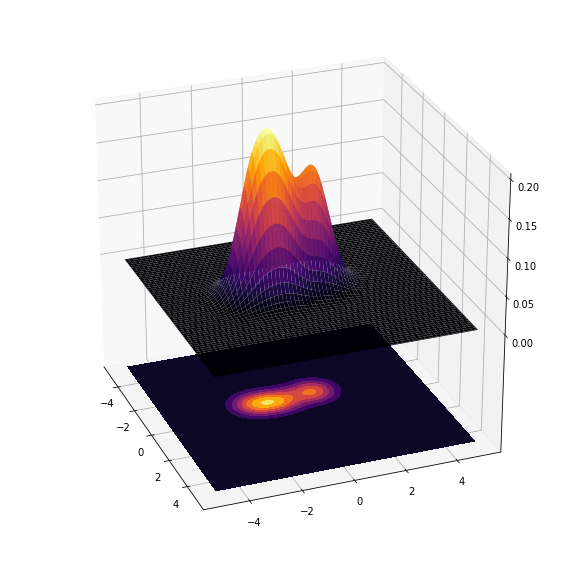

In [6]:
def plot_density_3d(x, y, loglike):
    fig = plt.figure(figsize=(10, 10))    
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, loglike, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(x, y, loglike, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
    plt.show()
    
plot_density_3d(*get_density())

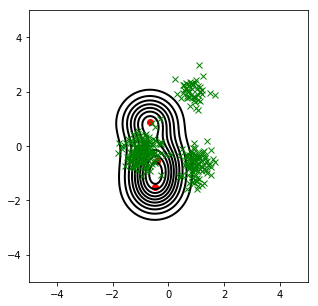

In [7]:
def plot_density_2d(x, y, loglike):
    fig = plt.figure(figsize=(5, 5))
    
    plt.plot(samples_dict["x"][:,0].data.numpy(), samples_dict["x"][:,1].data.numpy(), 'gx')
    
    for d in distributions:
        plt.scatter(d.constant_params_dict["loc"][0], d.constant_params_dict["loc"][1], c='r', marker='o')
    
    cs = plt.contour(x, y, loglike, 10, colors='k', linewidths=2)
    plt.show()

plot_density_2d(*get_density())

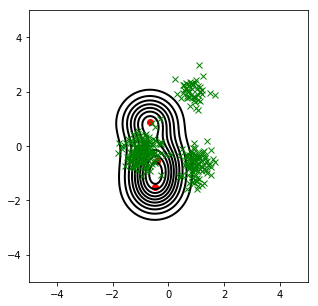

Epoch: -1, log-likelihood: -3.8614675998687744


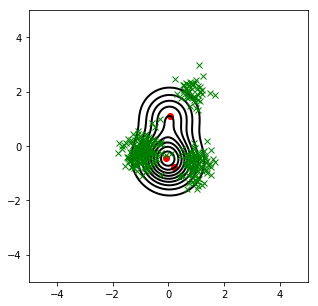

Epoch: 0, log-likelihood: -3.0529086589813232


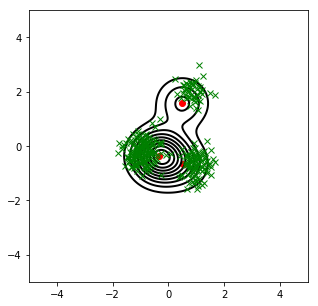

Epoch: 1, log-likelihood: -2.547523021697998


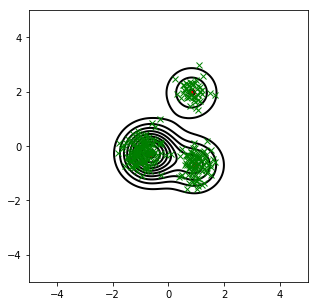

Epoch: 2, log-likelihood: -2.202068567276001


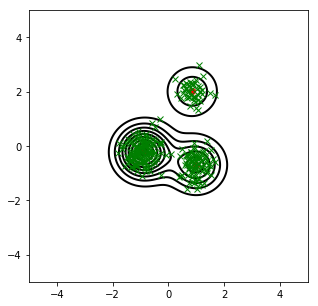

Epoch: 3, log-likelihood: -2.139308452606201


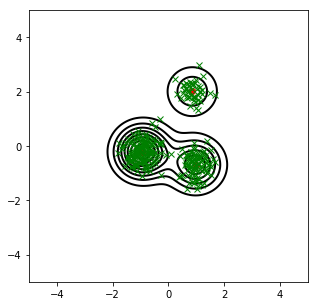

Epoch: 4, log-likelihood: -2.135385513305664


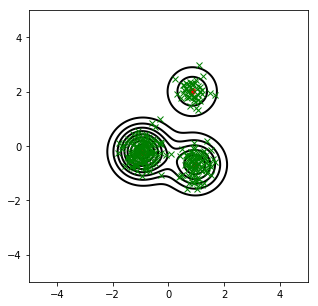

Epoch: 5, log-likelihood: -2.135241746902466


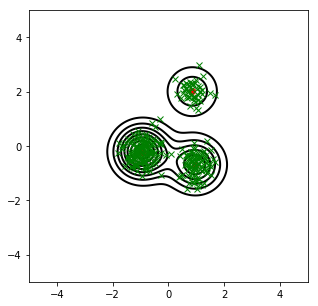

Epoch: 6, log-likelihood: -2.1352360248565674


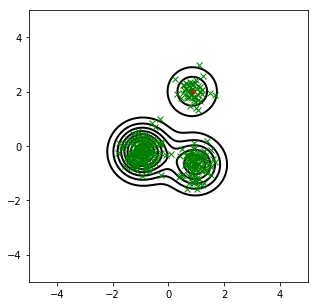

Epoch: 7, log-likelihood: -2.1352357864379883


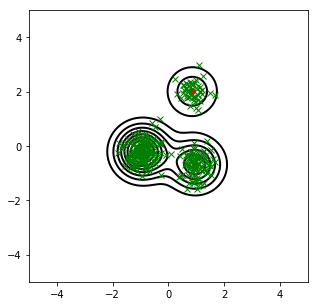

Epoch: 8, log-likelihood: -2.1352357864379883


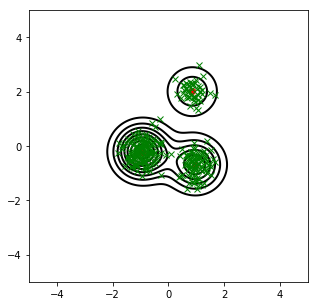

Epoch: 9, log-likelihood: -2.1352357864379883


In [8]:
eps = 1e-6
min_scale = 1e-6

#plot_density_3d(*get_density())
plot_density_2d(*get_density())
print("Epoch: {}, log-likelihood: {}".format(-1, p.log_likelihood(samples_dict).mean()))
for epoch in range(10):
    # E-step
    posterior = p.get_posterior_probs(samples_dict)

    # M-step
    N_k = posterior.sum(dim=1)  # (n_mix,)
    
    ## update probs
    probs = N_k / N_k.sum()  # (n_mix,)
    prior.constant_params_dict["probs"] = probs
    
    ## update loc & scale
    loc = (posterior[:, None] @ samples[None]).squeeze(1)  # (n_mix, n_dim)
    loc /= (N_k[:, None] + eps)

    cov = (samples[None, :, :] - loc[:, None, :]) ** 2

    scale = (posterior[:, None] @ cov).squeeze(1)  # (n_mix, n_dim)
    scale /= (N_k[:, None] + eps)
    scale = torch.clamp(scale, min=min_scale)

    for i, d in enumerate(distributions):
        d.constant_params_dict["loc"] = loc[i]
        #d.constant_params_dict["scale"] = scale[i]

#    plot_density_3d(*get_density())
    plot_density_2d(*get_density())        
    print("Epoch: {}, log-likelihood: {}".format(epoch, p.log_likelihood({"x": samples}).mean()))

In [9]:
print(p._prior.constant_params_dict)
print(p._distributions[0].constant_params_dict)
print(p._distributions[1].constant_params_dict)
print(p._distributions[2].constant_params_dict)

{'probs': tensor([0.3361, 0.1672, 0.4967])}
{'loc': tensor([ 0.9670, -0.6899]), 'scale': tensor([0.6000, 0.6000])}
{'loc': tensor([0.8537, 2.0117]), 'scale': tensor([0.6000, 0.6000])}
{'loc': tensor([-0.9416, -0.2103]), 'scale': tensor([0.6000, 0.6000])}
